In [1]:
import scanpy as sc
import pandas as pd
from pathlib import Path
import anndata as ad
import numpy as np

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

DPI = 300
FONTSIZE = 20  # 42

sc.settings.set_figure_params(
    scanpy=True, dpi=100, transparent=True, vector_friendly=True, dpi_save=DPI
)
from matplotlib import rcParams

rcParams["pdf.fonttype"] = 42

In [2]:
DIR2SAVE = Path("/data/BCI-CRC/nasrine/data/CRC/Primary_CRC_dataset/final_object/20mt/")
DIR2SAVE.mkdir(parents=True, exist_ok=True)

FIG2SAVE = DIR2SAVE.joinpath("figures/")
FIG2SAVE.mkdir(parents=True, exist_ok=True)
# set the global variable: sc.settings.figdir to save all plots
sc.settings.figdir = FIG2SAVE

### Read data (has TME + epi annotations)

In [3]:
adata = sc.read_h5ad(DIR2SAVE.joinpath("SMC_KUL_Pelka_Che_Wu_pCRC_annotations.h5ad"))
adata.shape

(246779, 2000)

In [4]:
adata.obs.cell_source.value_counts()

Pelka    129560
Che       43490
SMC       41319
Wu        26484
KUL        5926
Name: cell_source, dtype: int64

In [5]:
adata.obs.Patient.unique()

['SMC01', 'SMC02', 'SMC03', 'SMC04', 'SMC06', ..., 'Wu2021_P15', 'Wu2021_P17', 'Wu2021_P18', 'Wu2021_P19', 'Wu2021_P20']
Length: 117
Categories (117, object): ['C103_T', 'C104_T', 'C105_T', 'C106_T', ..., 'Wu2021_P6', 'Wu2021_P7', 'Wu2021_P8', 'Wu2021_P9']

In [6]:
len(adata.obs.Patient)

246779

In [7]:
adata.obs.Annotation_scVI.value_counts()

T-NK-ILC       94119
Epithelial     60526
Myeloid        36905
Plasma         24526
B              19701
Stromal         5367
Endothelial     3047
Mast            2588
Name: Annotation_scVI, dtype: int64

### palette colours 

In [8]:
pal_dict = {"B": "#BEBADA",
            "Endothelial": "#8DD3C7",
            "Epithelial": "#FB8072",#E41A1C #FB8072
            #"Hepatocyte": "#FDB462",
            "Mast": "#fccde5", #"#000000",
            "Myeloid": "#80B1D3",
            "Plasma": "#7570B3",#B3B3B3
            "Stromal": "#B3DE69",
            "T-NK-ILC": "#F781BF"
           }

In [9]:
adata.uns["Annotation_scVI_colors"] = list(pal_dict.values())

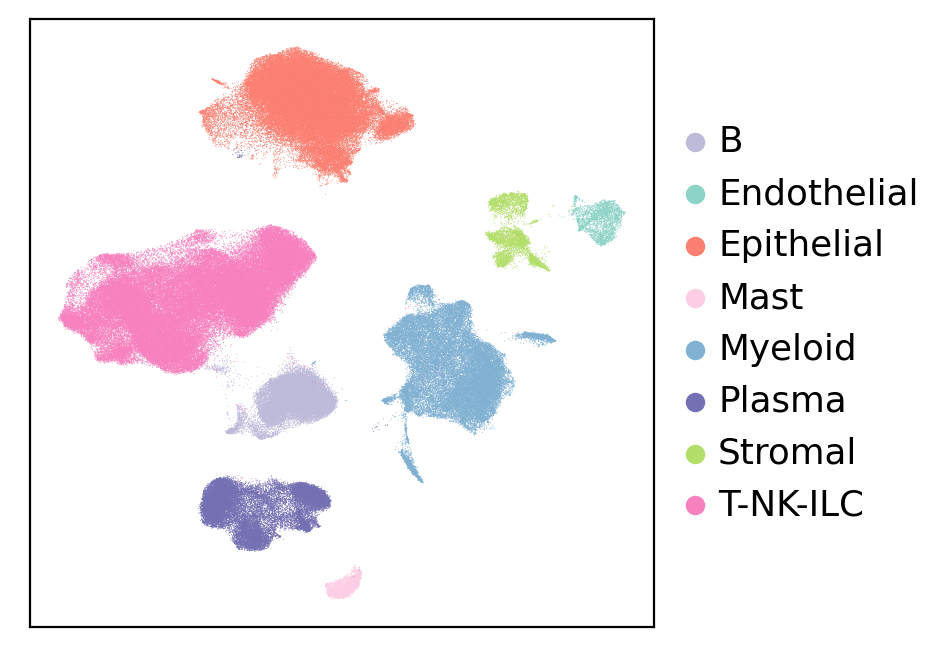

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=1, sharey=False, sharex=False)
sc.pl.umap(adata, color="Annotation_scVI", title="", ax=ax, show=False)
ax.set_xlabel("")
ax.set_ylabel("")
plt.savefig(FIG2SAVE.joinpath("Annotation_global.pdf"), bbox_inches='tight', dpi=DPI)

In [11]:
FIG2SAVE

PosixPath('/data/BCI-CRC/nasrine/data/CRC/Primary_CRC_dataset/final_object/20mt/figures')

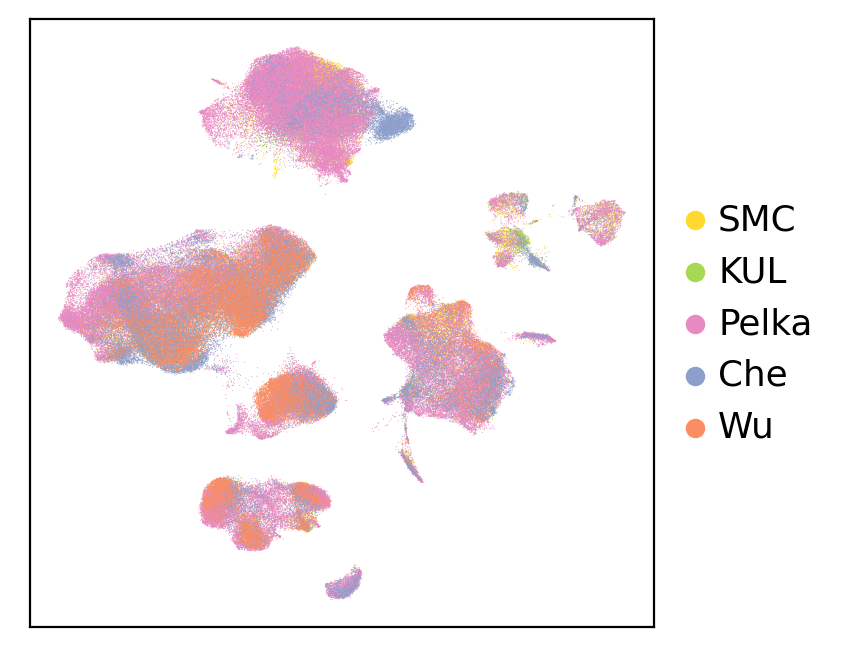

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=1)
sc.pl.umap(adata, color="cell_source", title="", ax=ax, show=False)
ax.set_xlabel("")
ax.set_ylabel("")
fig.savefig(FIG2SAVE.joinpath("cell_source_global.pdf"), dpi=DPI, bbox_inches="tight")

### plot proportion per cell type

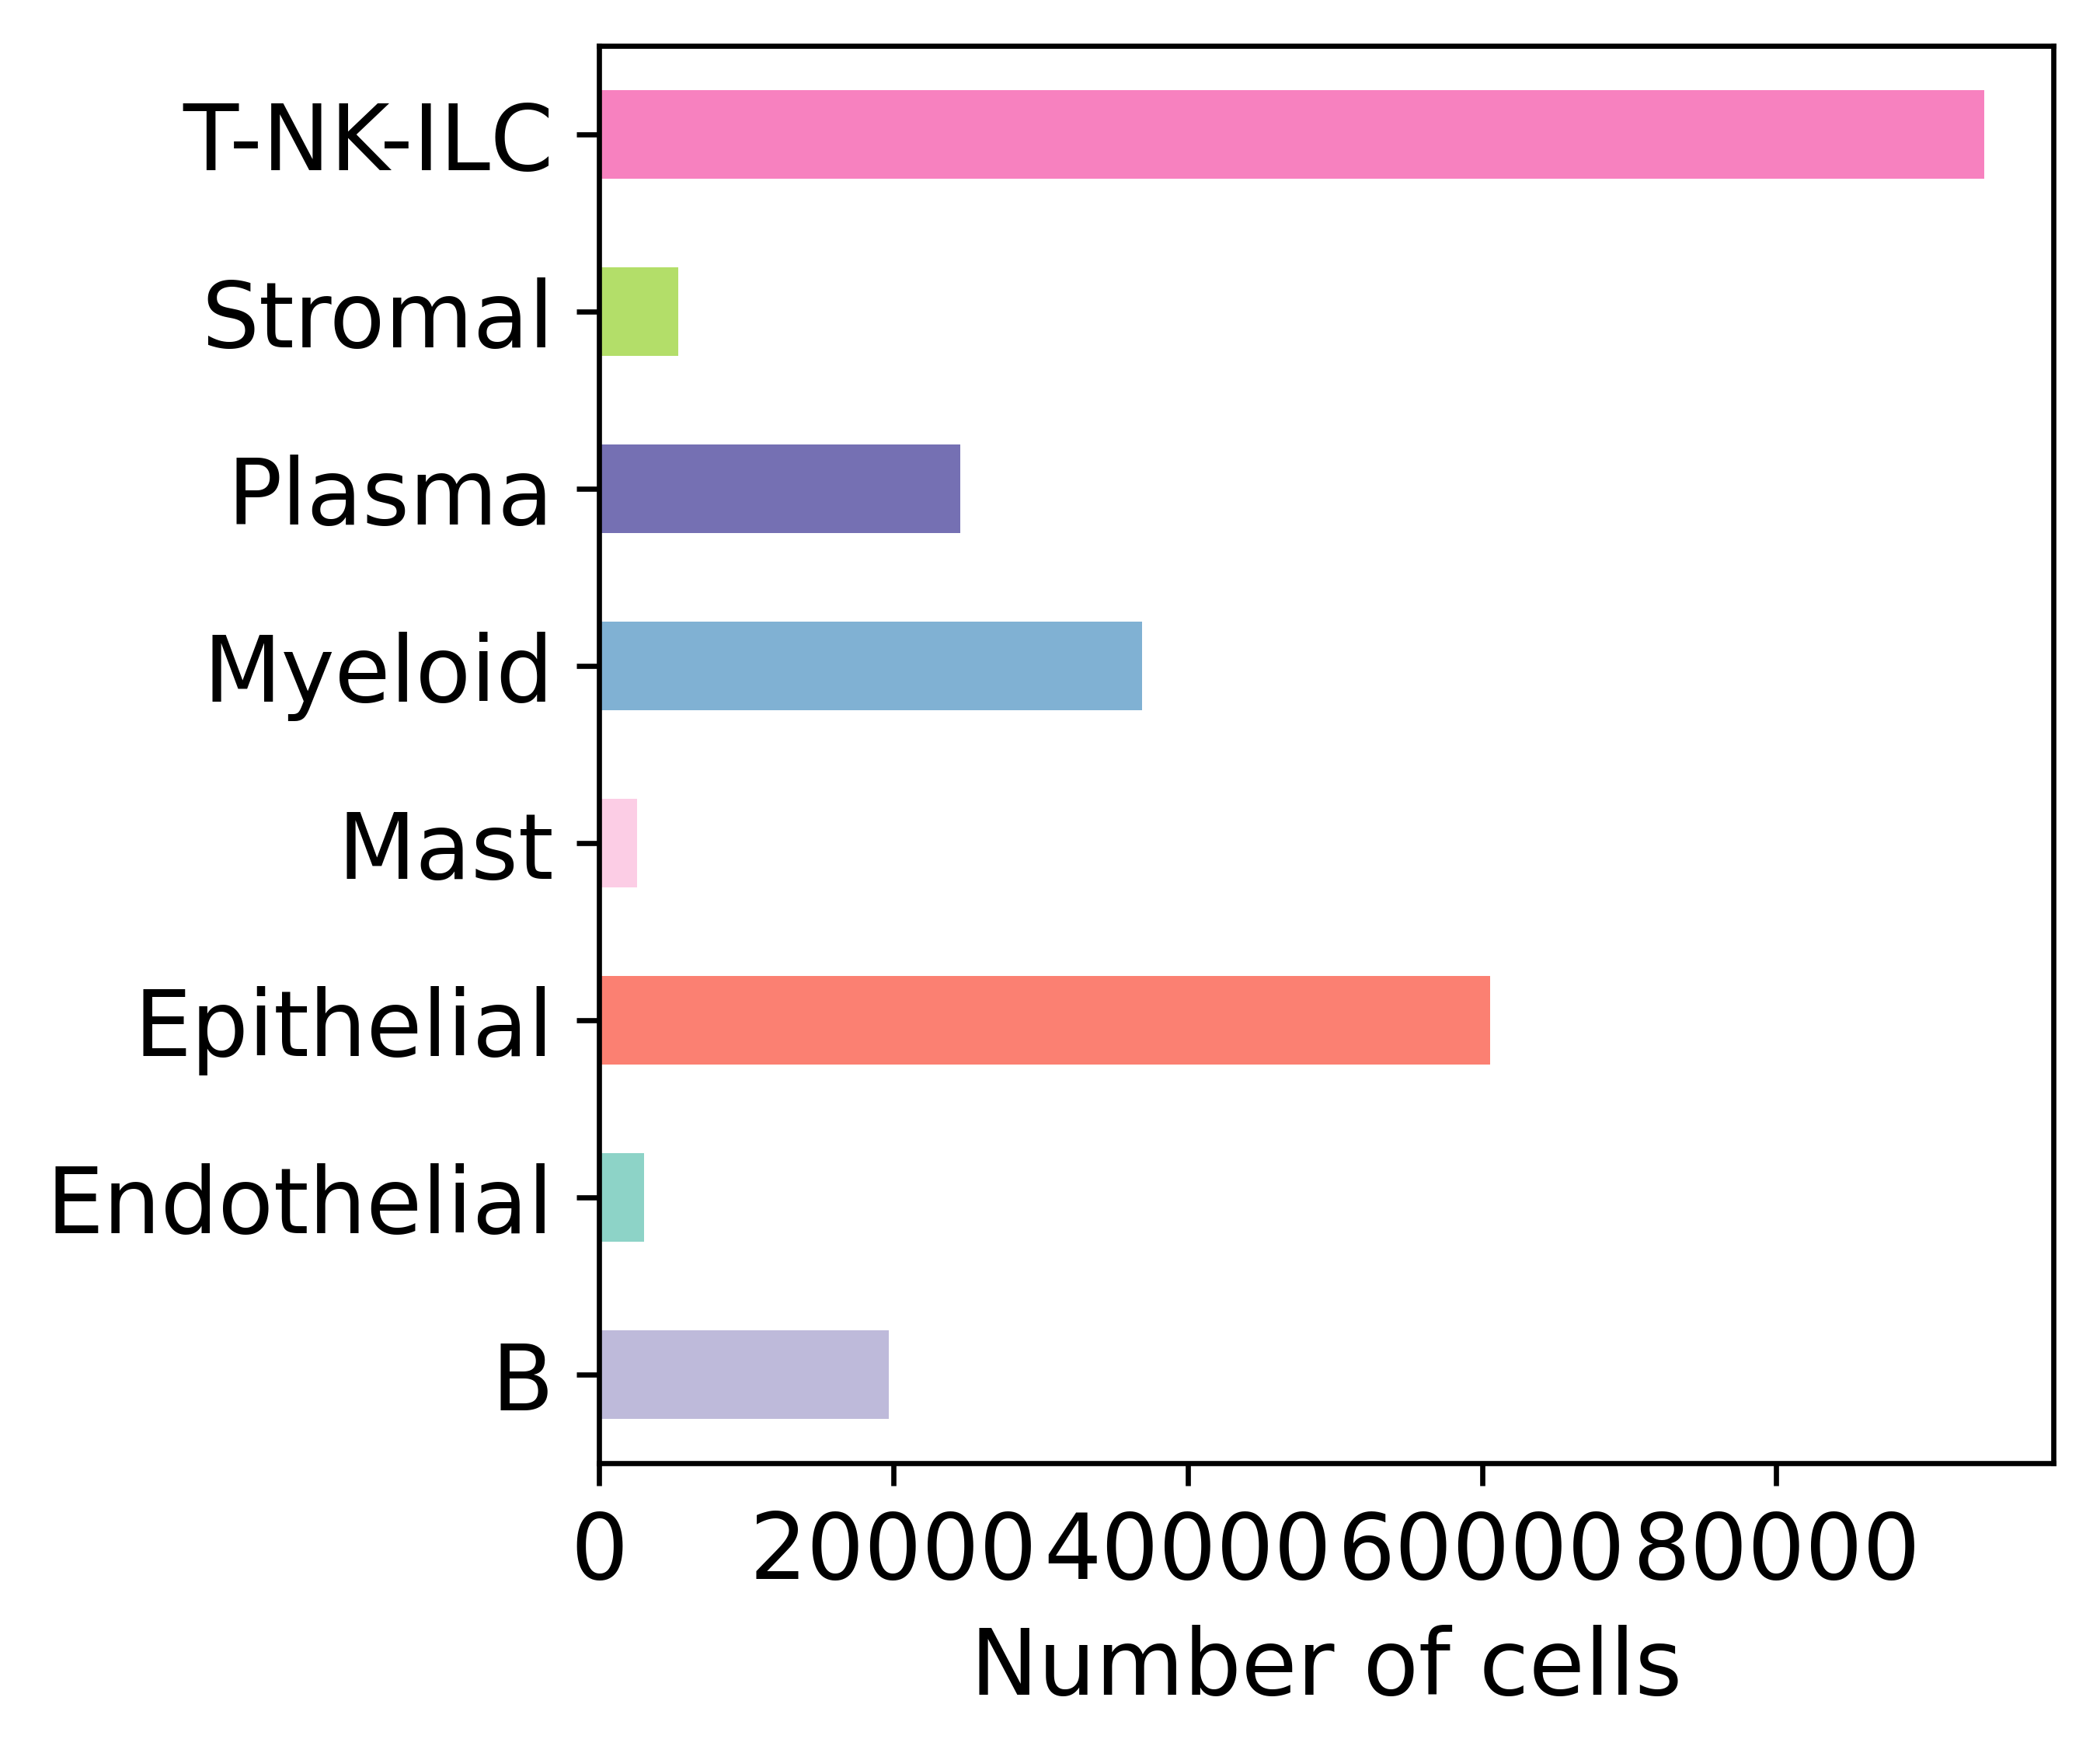

In [13]:
from collections import OrderedDict

color_dict = OrderedDict(
    zip(
        adata.obs["Annotation_scVI"].cat.categories.values.tolist(),
        adata.uns["Annotation_scVI_colors"],
    )
)

fig, ax = plt.subplots(nrows=1, ncols=1, sharey=False, sharex=False, dpi=DPI)
adata.obs.groupby("Annotation_scVI").size().plot.barh(color=color_dict.values(), ax=ax)
ax.set_ylabel("")
ax.set_xlabel("Number of cells")
ax.grid(False, which="major", axis="both")  # removes major horizontal gridlinesd
plt.savefig(FIG2SAVE.joinpath("barplot_nb_cells_celltype.pdf"), bbox_inches='tight')

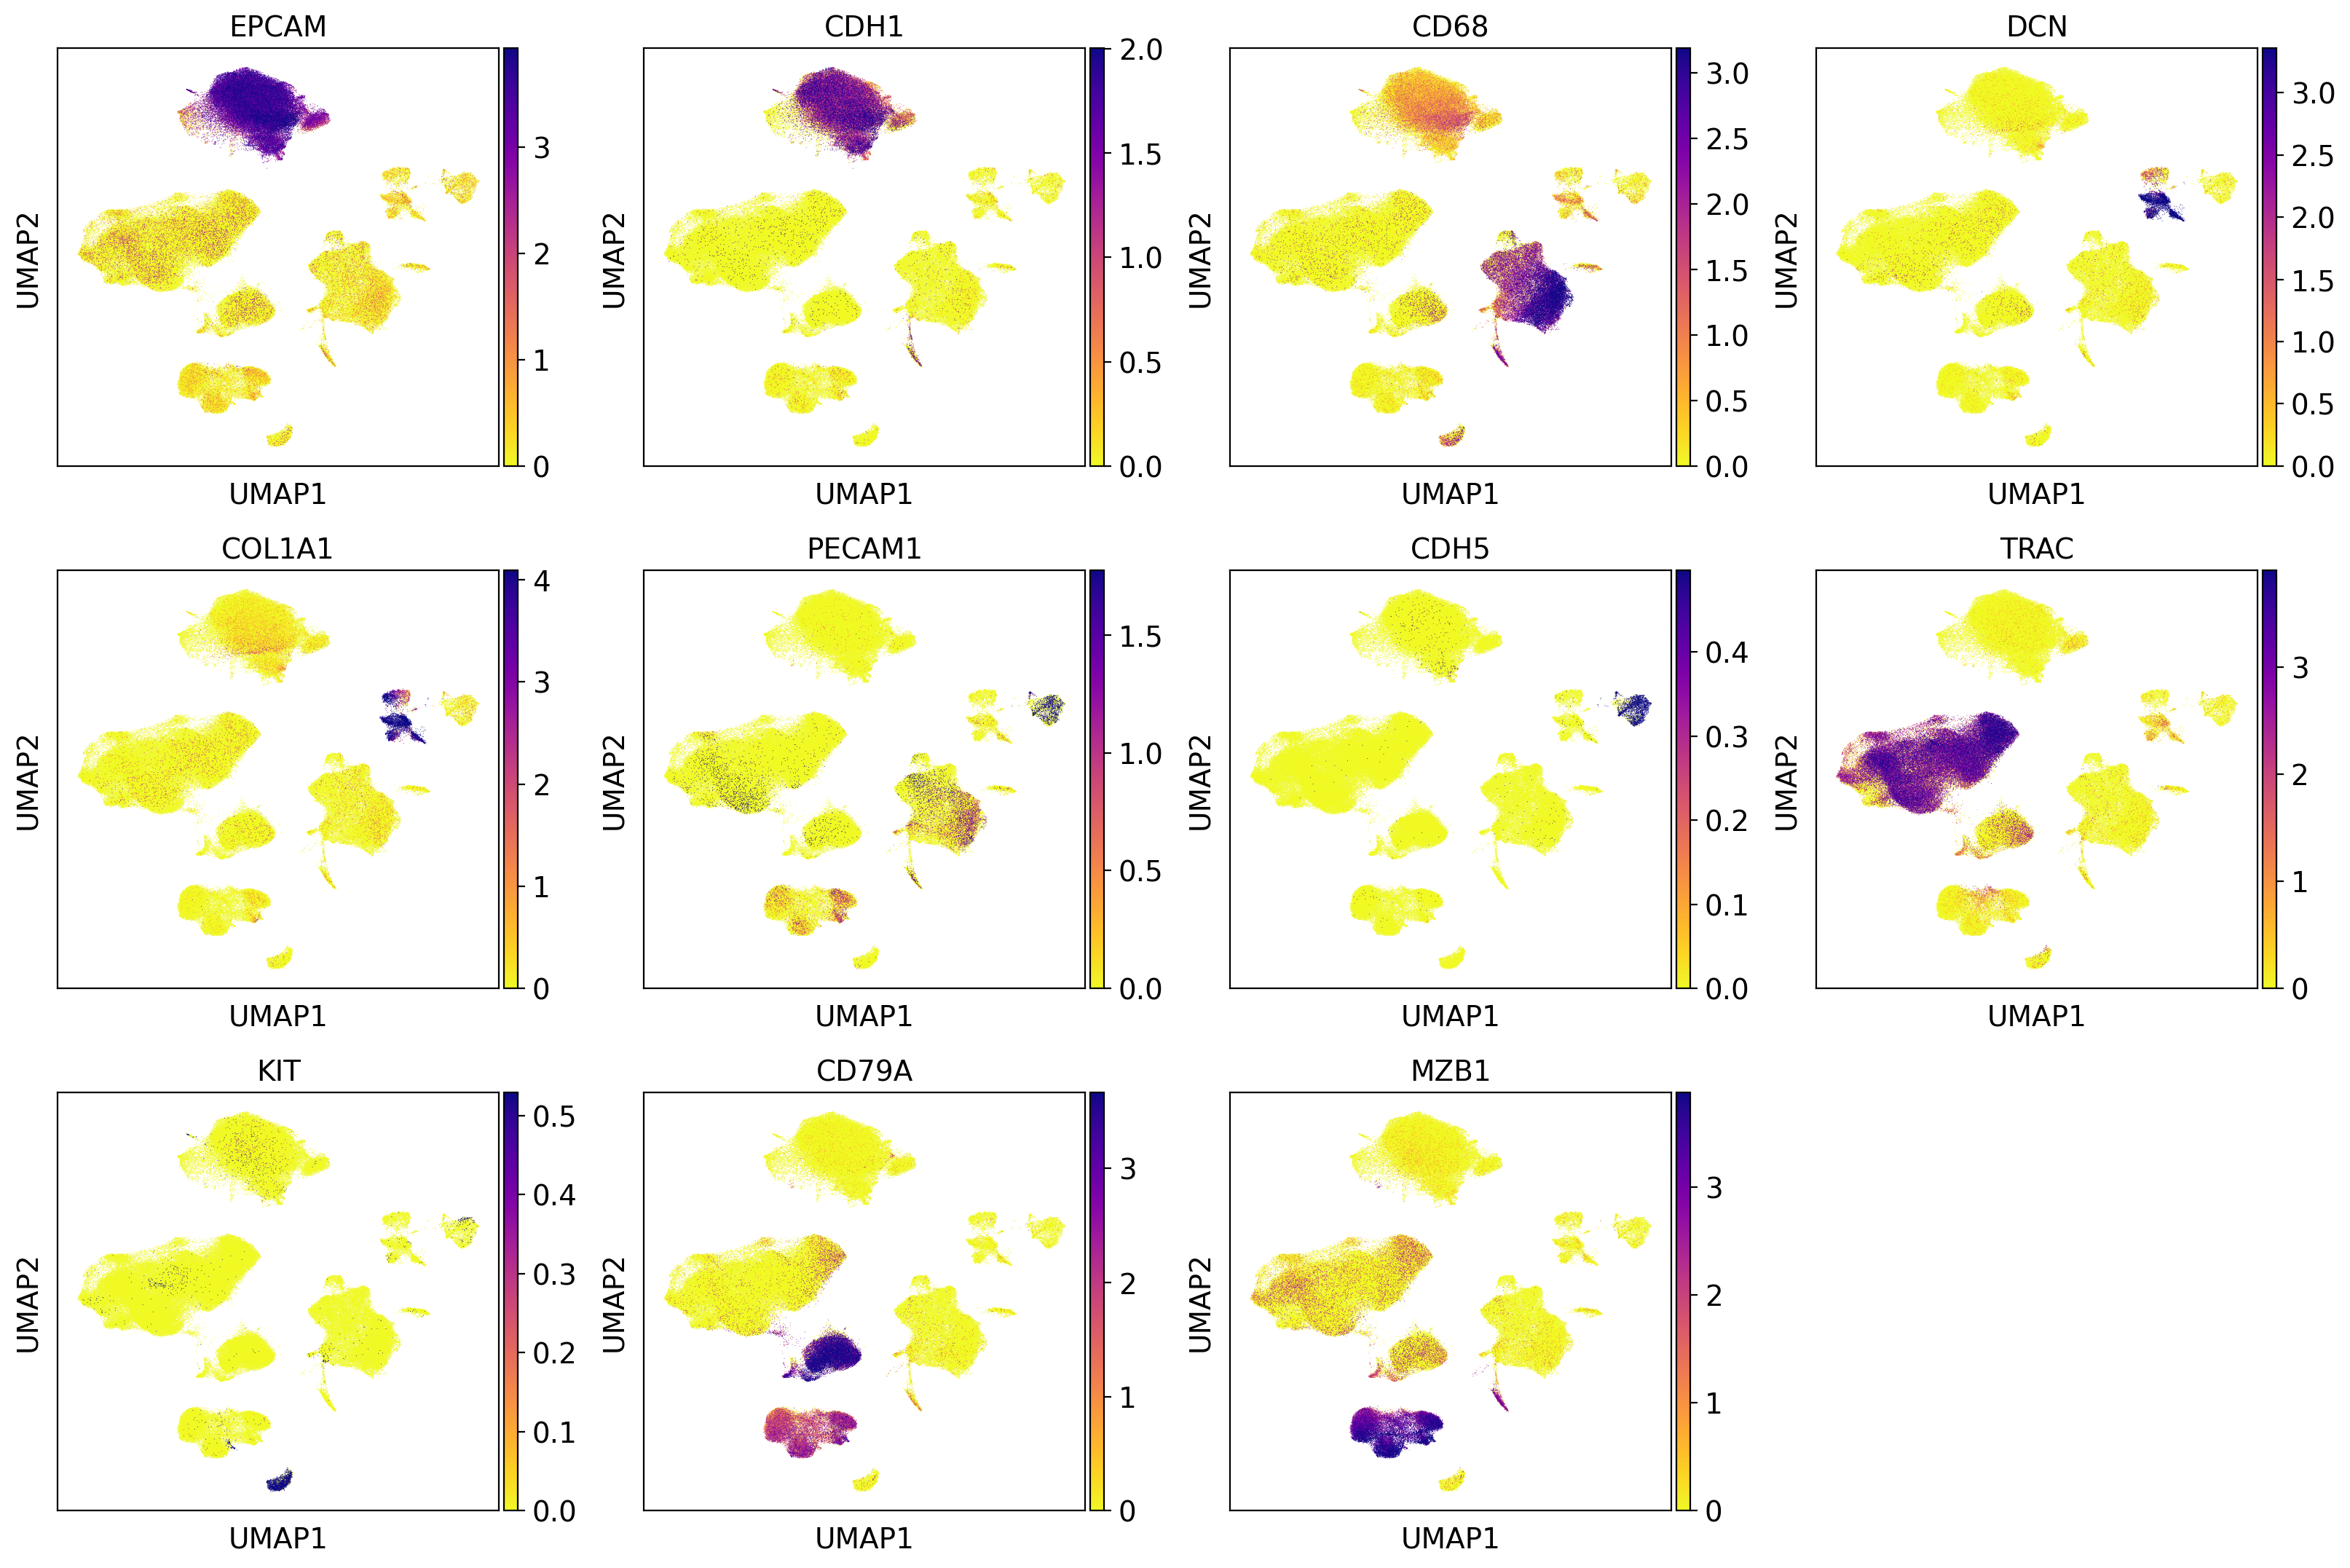

In [14]:
marker_subset = [
    "EPCAM",
    "CDH1",
    "CD68",
    "DCN",
    #"VCAM1",
    "COL1A1",
    "PECAM1",
    "CDH5",
    "TRAC",
    "KIT",
    "CD79A",
    "MZB1",
]
sc.pl.umap(
    adata,
    color=marker_subset,
    use_raw=True,
    vmin=0.0,
    vmax="p99",
    color_map="plasma_r",
    save="general_markers_major_celltypes.pdf",
    show=True,
)

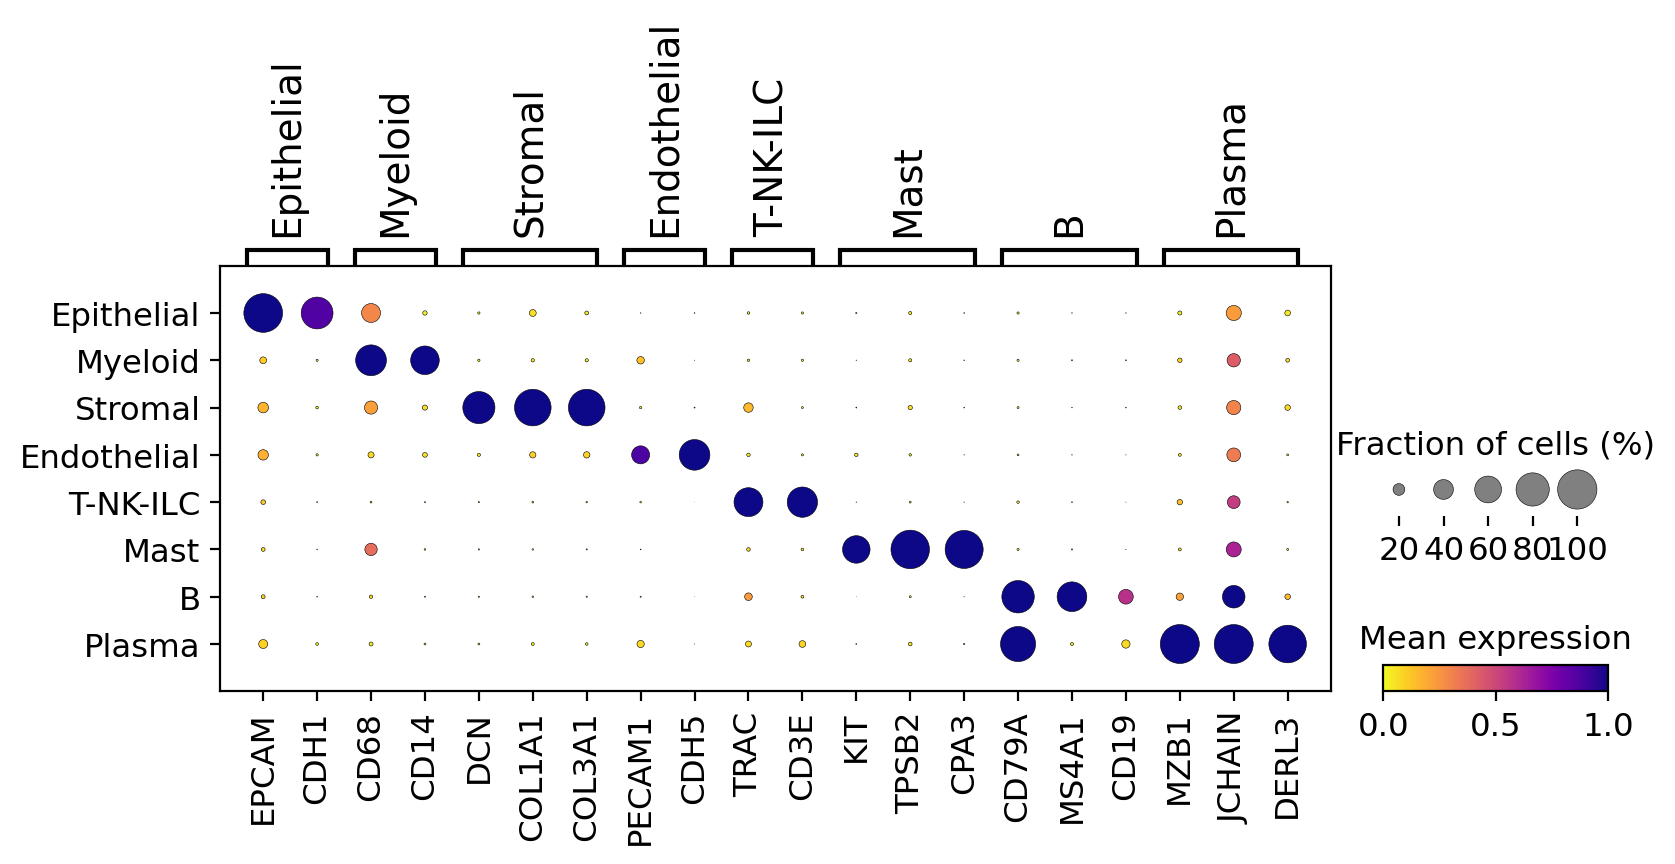

In [15]:
markers_short_list = {
    "Epithelial": ["EPCAM", "CDH1"],
    "Myeloid": ["CD68", "CD14"],
    "Stromal": ["DCN", "COL1A1","COL3A1"],
    "Endothelial": ["PECAM1", "CDH5"],
    "T-NK-ILC": ["TRAC", "CD3E"],
    "Mast": ["KIT", "TPSB2", "CPA3"], # "GATA2"
    "B": ["CD79A", "MS4A1", "CD19"],
    "Plasma": ["MZB1", "JCHAIN", "DERL3"], # "SDC1",  
}

sc.pl.dotplot(
    adata,
    groupby="Annotation_scVI",
    categories_order=markers_short_list.keys(),
    use_raw=True,
    var_names=markers_short_list,
    cmap="plasma_r",
    #standard_scale="var",
    vmin=0,
    vmax=1,
    colorbar_title="Mean expression",
    size_title = "Fraction of cells (%)",
    dendrogram=False,
    save="dotplot_mean_general_short.pdf",
    show=True,
)

### zscore

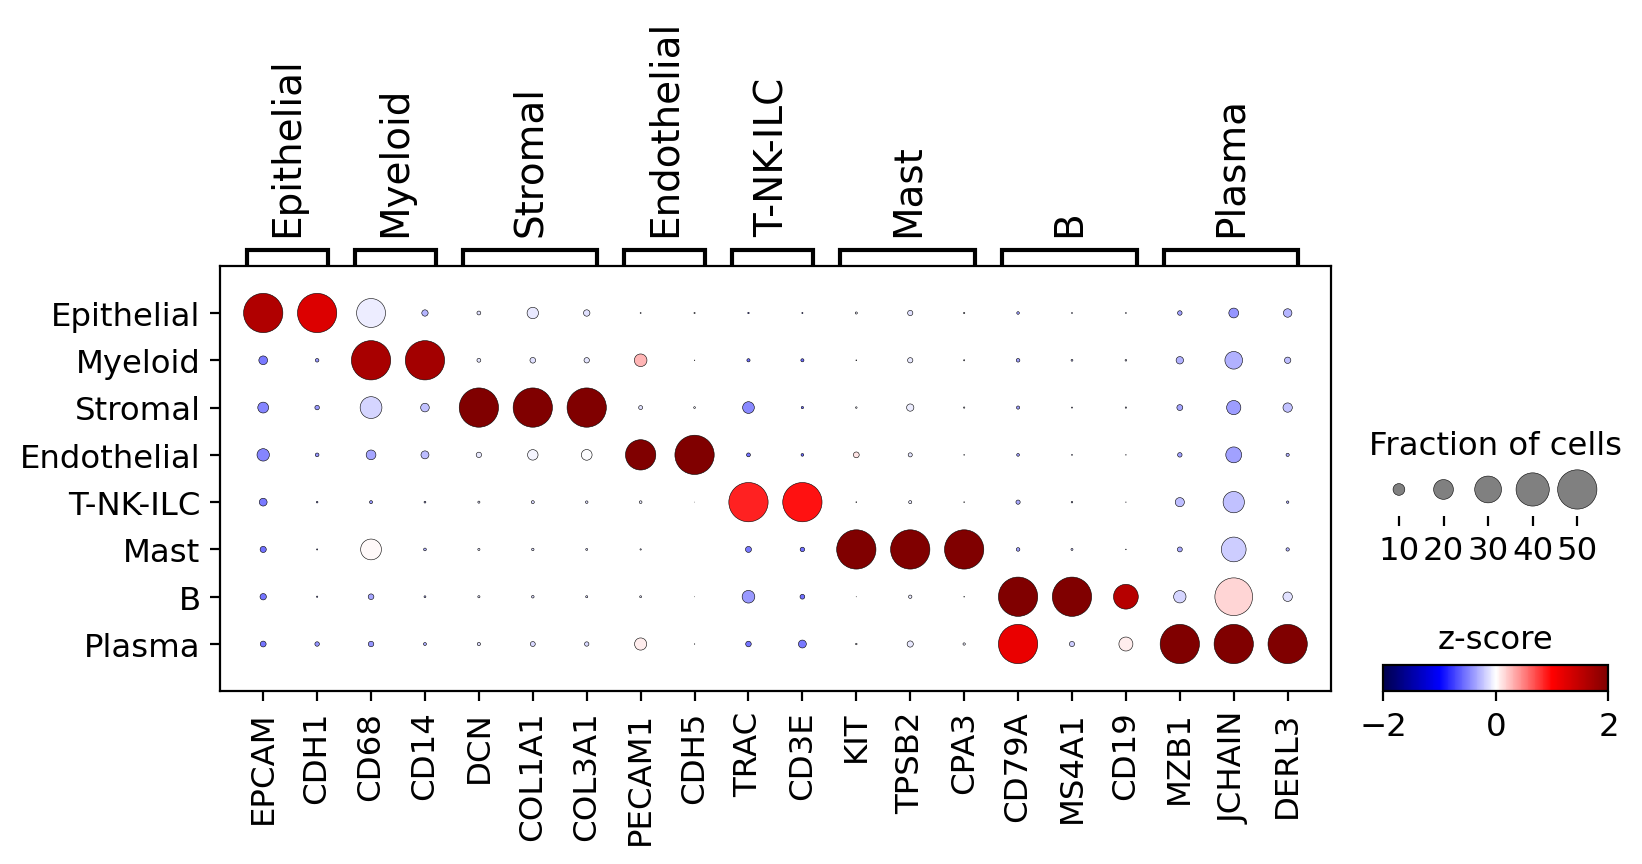

In [16]:
adata_zscore = adata.raw.to_adata().copy()
# scale and store results in layer for later plotting
adata_zscore.layers['scaled'] = sc.pp.scale(adata_zscore, copy=True).X
adata_zscore.obs=adata.obs
sc.pl.dotplot(adata=adata_zscore, 
              var_names=markers_short_list,
              groupby="Annotation_scVI",
              categories_order=markers_short_list.keys(),
              cmap="seismic", 
              layer="scaled", 
              vmin=-2,
              vmax=2, 
              dot_max=0.5, 
              colorbar_title = "z-score", 
              size_title="Fraction of cells",
              save='zscore_general.pdf')

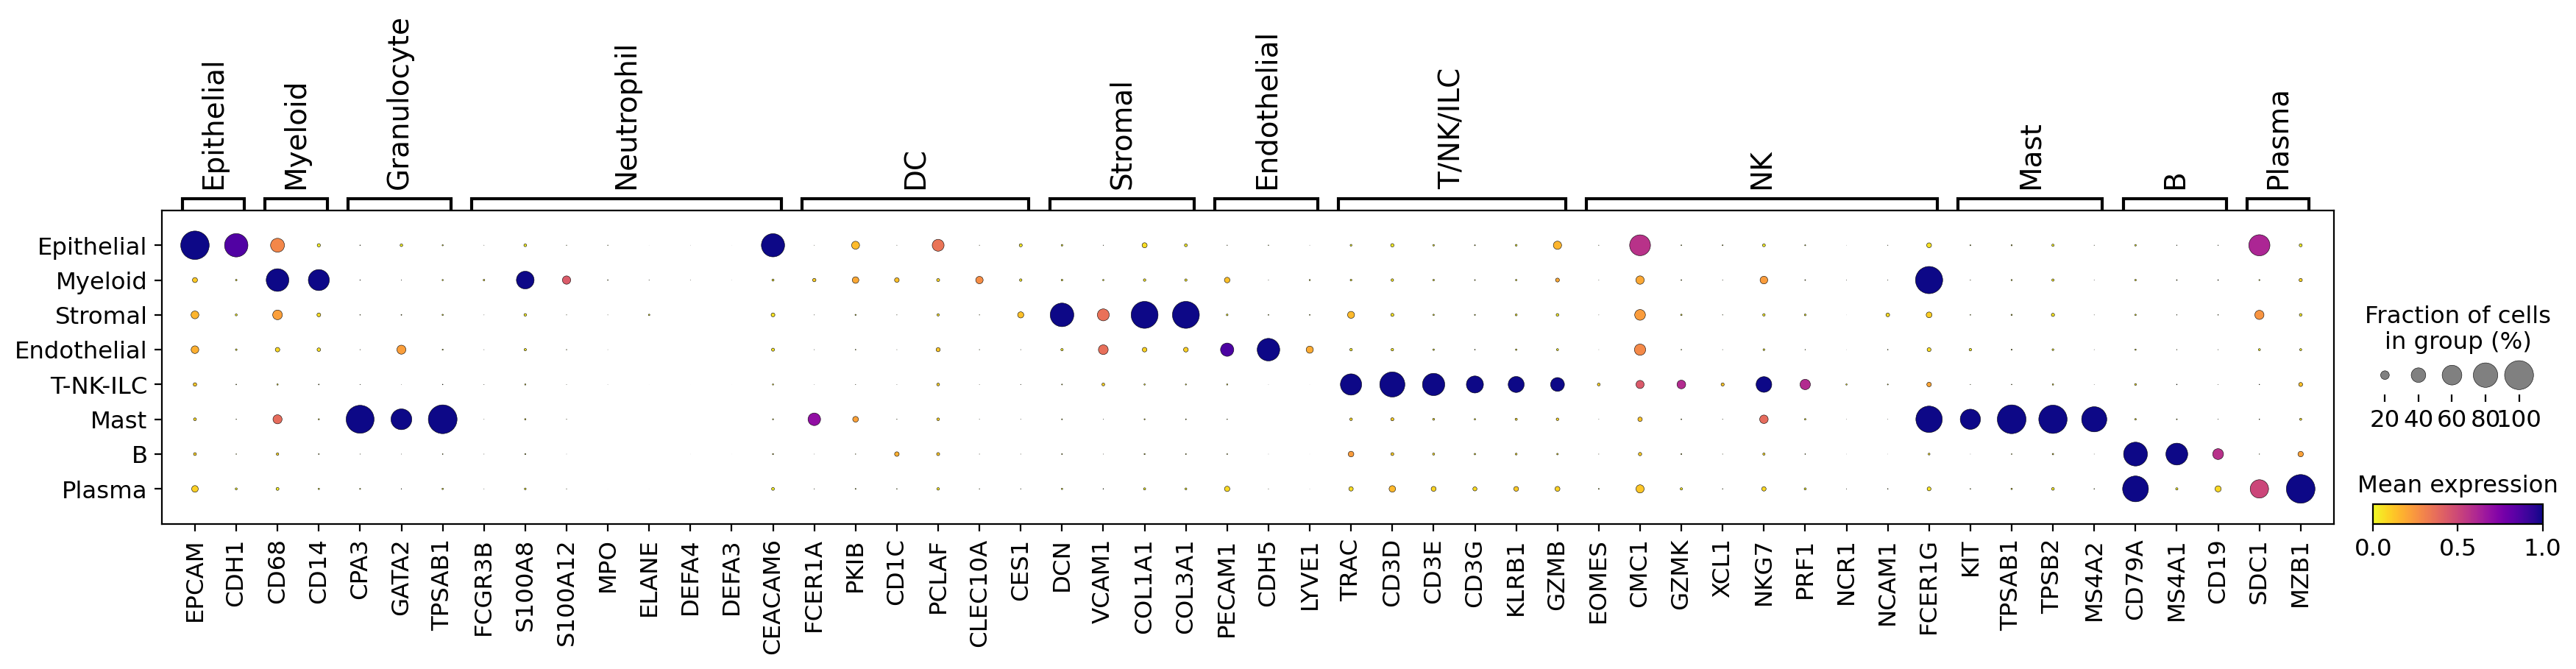

In [17]:
markers = {
    "Epithelial": ["EPCAM", "CDH1"],
    "Myeloid": ["CD68", "CD14"],
    #"Kupffer": ["SLC11A1", "CD5L", "TIMD4", "CETP"],
    "Granulocyte": ["CPA3", "GATA2", "TPSAB1"],
    "Neutrophil": [
        "FCGR3B",
        "S100A8",
        "S100A12",
        "MPO",
        "ELANE",
        "DEFA4",
        "DEFA3",
        "CEACAM6",
    ],
    "DC": ["FCER1A", "PKIB", "CD1C", "PCLAF", "CLEC10A", "CES1"],
    "Stromal": ["DCN", "VCAM1", "COL1A1", "COL3A1"],
    "Endothelial": ["PECAM1", "CDH5", "LYVE1"],
    "T/NK/ILC": ["TRAC", "CD3D", "CD3E", "CD3G", "KLRB1", "GZMB"],
    "NK": ["EOMES", "CMC1", "GZMK", "XCL1", "NKG7", "PRF1", "NCR1", "NCAM1", "FCER1G"],
    #"ILC": ["AREG", "TLE1", "IL4I1"],
    "Mast": ["KIT", "TPSAB1", "TPSB2", "MS4A2"],
    "B": ["CD79A", "MS4A1", "CD19"],
    "Plasma": ["SDC1", "MZB1"],
    # "Hepatocyte": ["ALB", "TTR", "APOA1", "AFP"],
    # "Cholangiocyte": ["SOX9", "EPCAM", "KRT19", "CLDN4", "CLDN10", "FXYD2"],
}


sc.pl.dotplot(
    adata,
    groupby="Annotation_scVI",
    categories_order=markers_short_list.keys(),
    use_raw=True,
    var_names=markers,
    cmap="plasma_r",
    #standard_scale="var",
    vmin=0,
    vmax=1,
    colorbar_title="Mean expression",
    dendrogram=False,
    save="dotplot_mean_general.pdf",
    show=True,
)

In [18]:
from matplotlib.patches import Rectangle


def proportion_cells_patient(
    adata, groupby_labels, xlabel: str, ylabel: str, colors: dict, figname: str
):  # colors
    # compute proportion of cells within each group
    table2plot = (
        adata.reset_index()
        .groupby(groupby_labels)
        .size()
        .groupby(level=0)
        .apply(lambda x: x * 100 / x.sum())
        .unstack()
    )

    fig, ax = plt.subplots(
        nrows=1,
        ncols=1,
        sharey=False,
        sharex=False,
        dpi=DPI,
    )  # figsize=(4, 4))

    print(table2plot)
    table2plot.plot.barh(stacked=True, ax=ax, color=colors.values())  # , color=colors
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.grid(False, which="major", axis="both")  # removes major horizontal gridlinesd

    labels = list(colors.keys())
    l = [Rectangle((0, 0), 0, 0, color=color) for color in list(colors.values())]
    ax.legend(
        l,
        labels,
        loc="upper left",
        bbox_to_anchor=(1, 0.8),
        facecolor="white",
        edgecolor="white",
        ncol=1,
        borderaxespad=0.0,
        framealpha=0,
        frameon=False,
    )

    plt.savefig(FIG2SAVE.joinpath(figname), dpi=DPI, format="pdf", bbox_inches="tight")
    plt.show()

cell_source            SMC        KUL      Pelka        Che         Wu
Annotation_scVI                                                       
B                10.278666   2.294300  45.840313  20.719760  20.866961
Endothelial      19.921234  13.455858  61.470299   5.152609   0.000000
Epithelial       22.373856   1.696791  66.639130   9.290222   0.000000
Mast              0.347759   2.859351  73.029366  23.570325   0.193199
Myeloid          15.412546   2.189405  58.043626  17.008535   7.345888
Plasma            7.644948   1.023404  62.305309  11.563239  17.463100
Stromal          28.805664  21.278181  33.258804  16.657350   0.000000
T-NK-ILC         17.028443   1.872098  40.315983  24.448836  16.334640


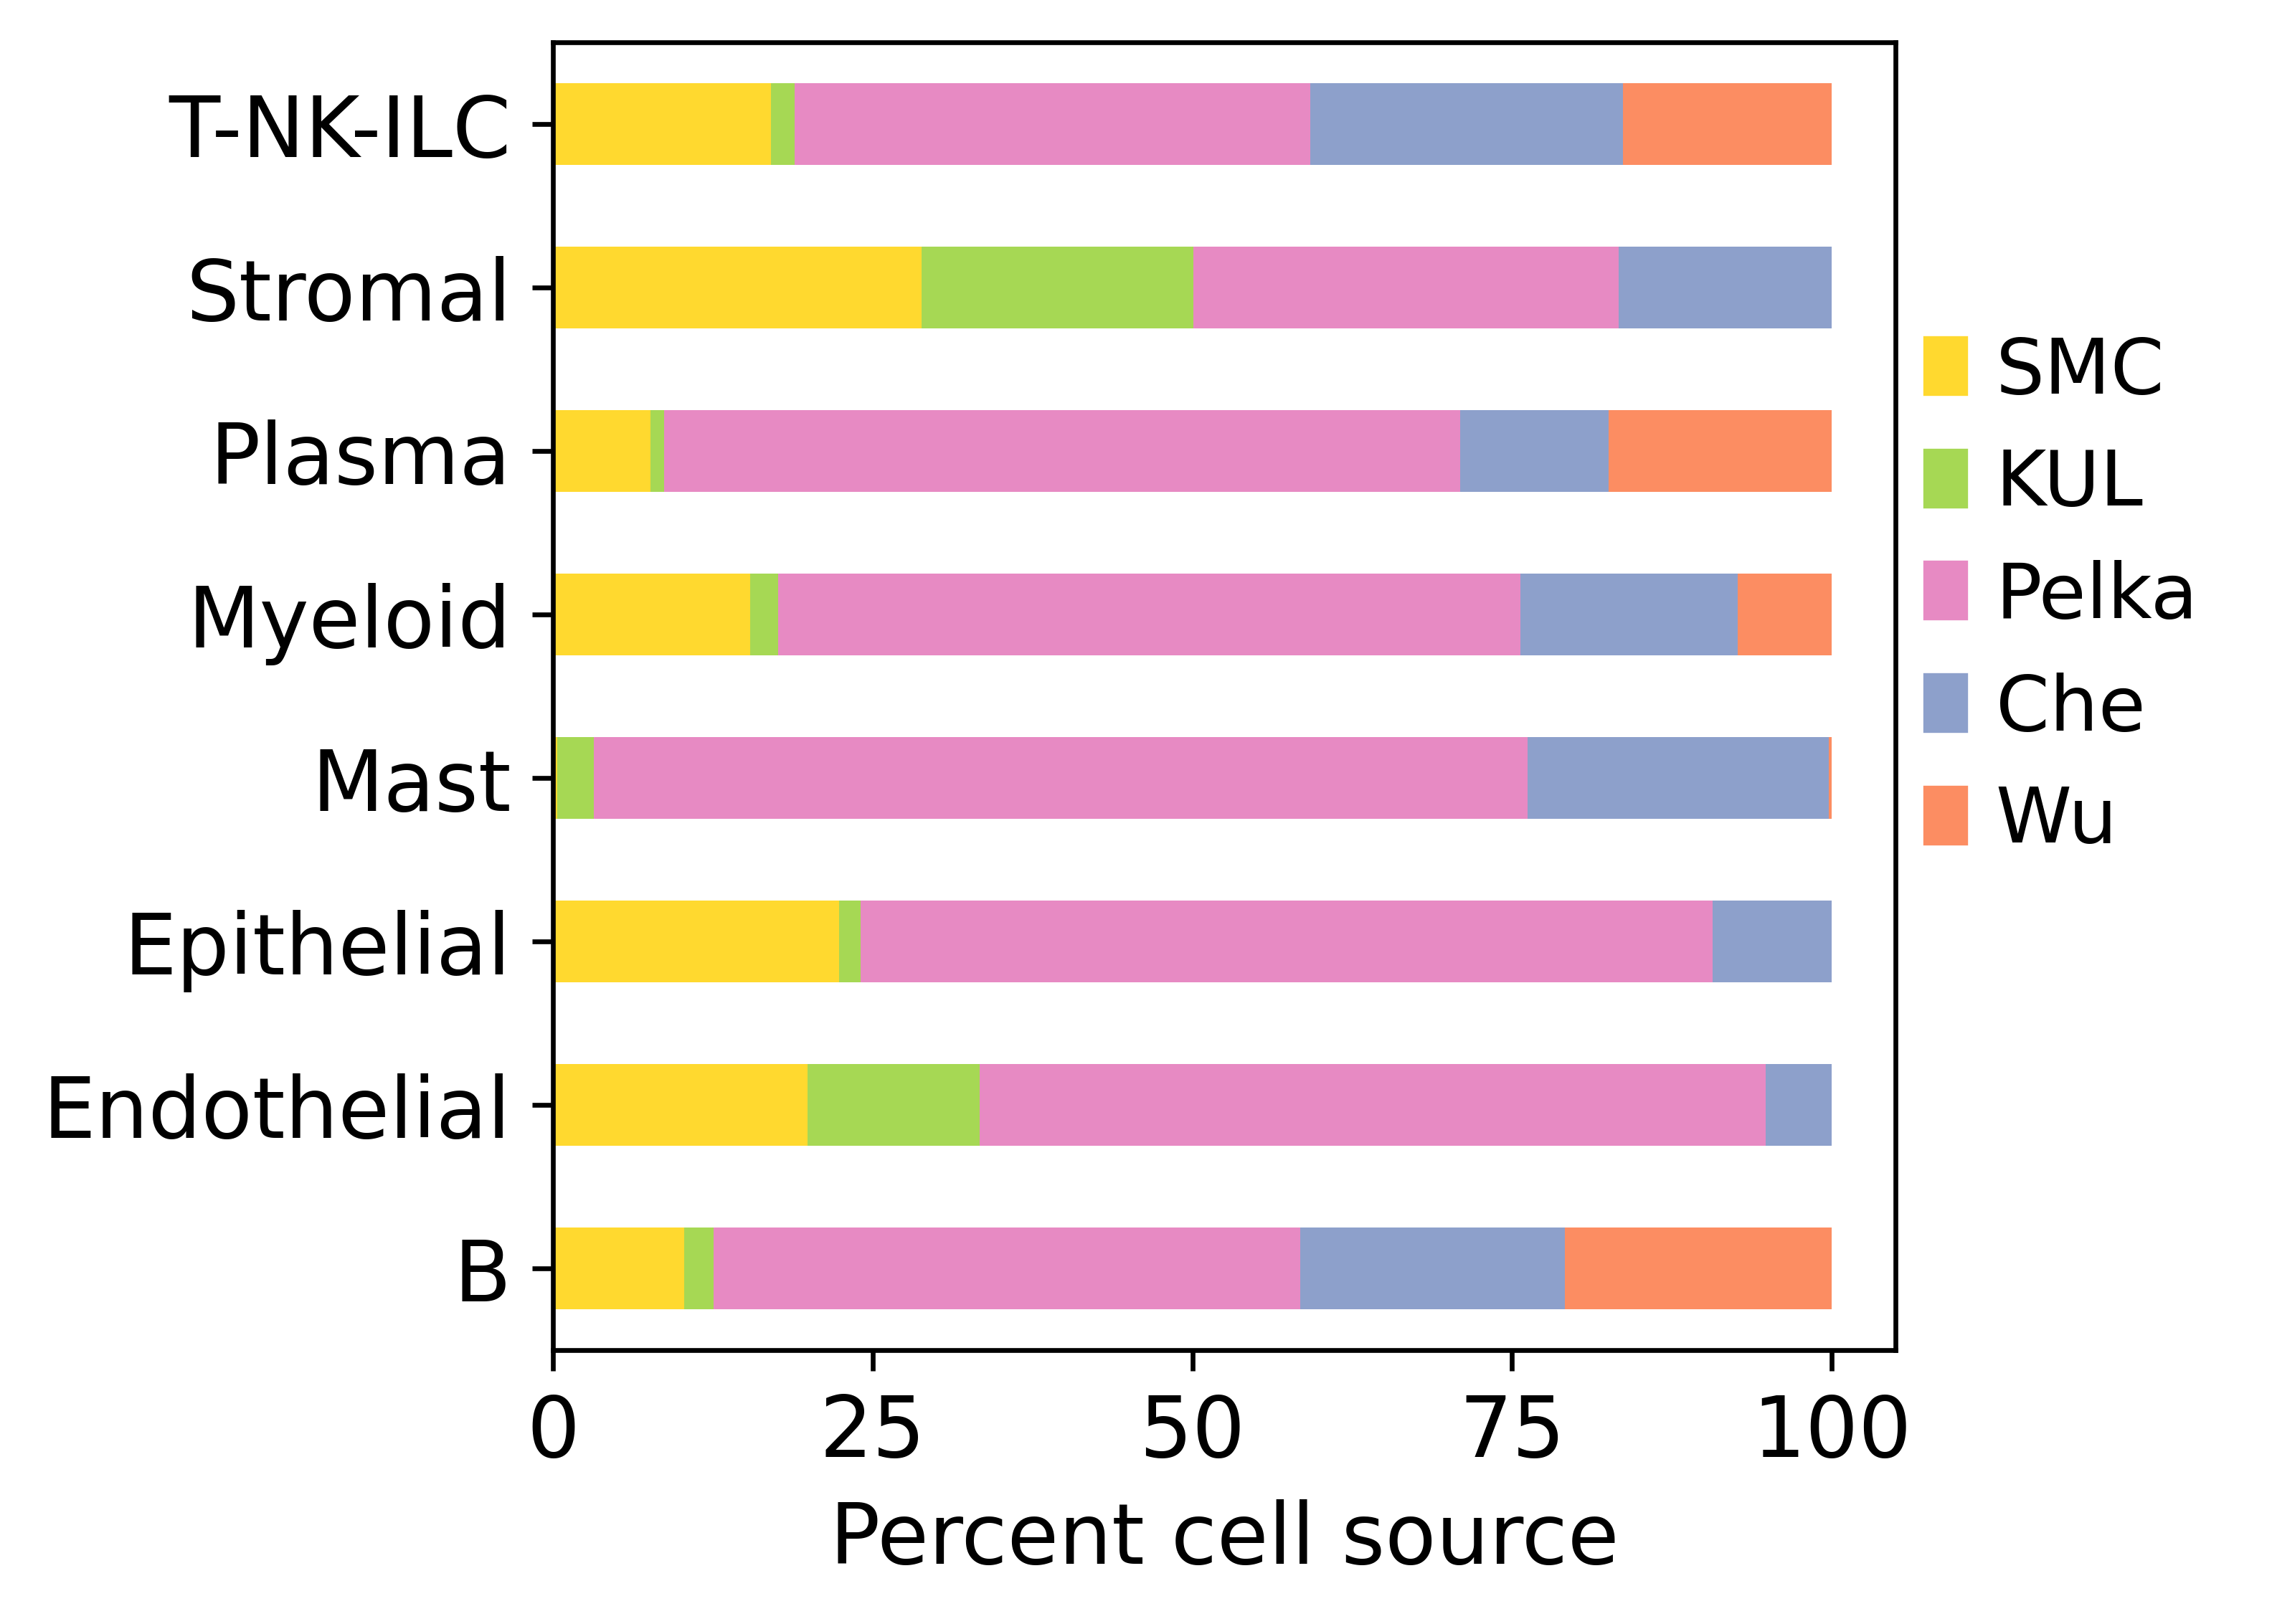

In [19]:
from collections import OrderedDict

color_dict = OrderedDict(
    zip(
        adata.obs["cell_source"].cat.categories.values.tolist(),
        adata.uns["cell_source_colors"],
    )
)

proportion_cells_patient(
    adata.obs,
    groupby_labels=["Annotation_scVI", "cell_source"],
    xlabel="Percent cell source",
    ylabel="",
    colors=color_dict,
    figname="annotation_cell_source.pdf",
)

Annotation_scVI          B  Endothelial  Epithelial      Mast    Myeloid  \
cell_source                                                                
SMC               4.900893     1.469058   32.774268  0.021782  13.766064   
KUL               7.627405     6.918664   17.330408  1.248734  13.634830   
Pelka             6.970516     1.445662   31.131522  1.458784  16.533652   
Che               9.386066     0.361003   12.929409  1.402621  14.433203   
Wu               15.522580     0.000000    0.000000  0.018879  10.236369   

Annotation_scVI     Plasma    Stromal   T-NK-ILC  
cell_source                                       
SMC               4.537864   3.741620  38.788451  
KUL               4.235572  19.271009  29.733378  
Pelka            11.794535   1.377740  29.287589  
Che               6.521039   2.055645  52.911014  
Wu               16.172028   0.000000  58.050143  


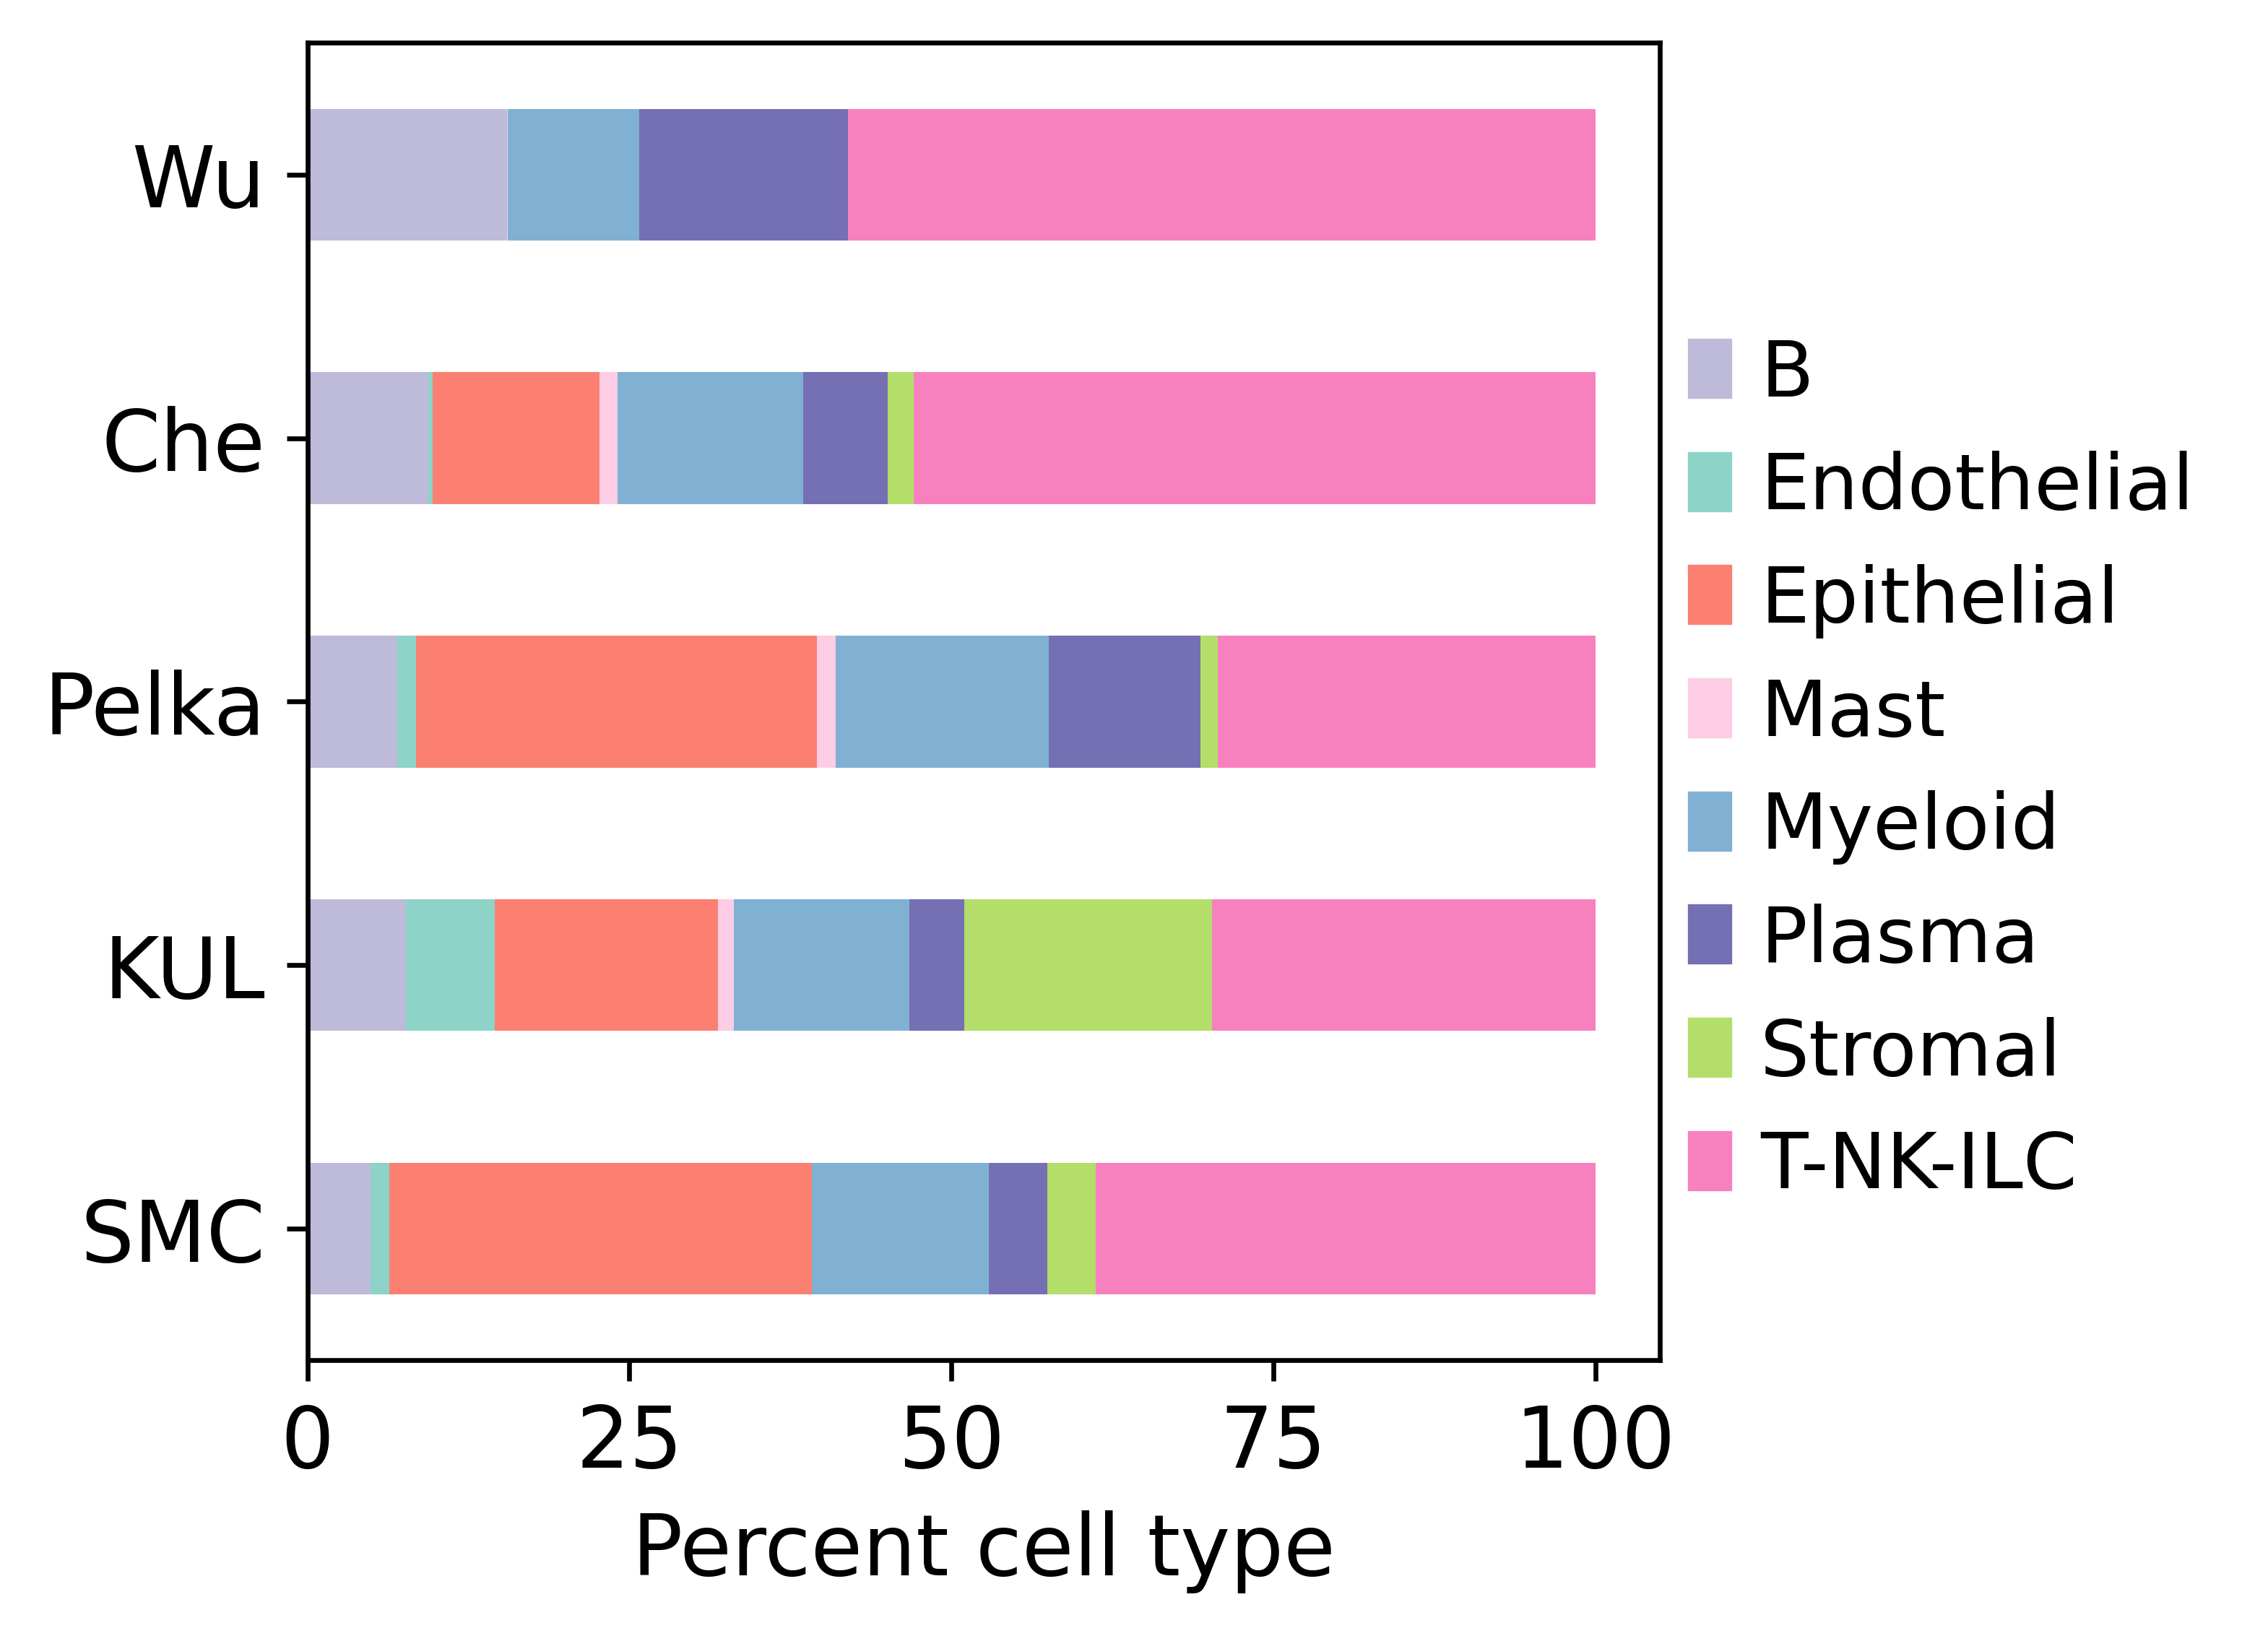

In [21]:
from collections import OrderedDict

color_dict = OrderedDict(
    zip(
        adata.obs["Annotation_scVI"].cat.categories.values.tolist(),
        adata.uns["Annotation_scVI_colors"],
    )
)

proportion_cells_patient(
    adata.obs,
    groupby_labels=["cell_source", "Annotation_scVI"],
    xlabel="Percent cell type",
    ylabel="",
    colors=color_dict,
    figname="annotation_cell_type.pdf",
)

In [22]:
FIG2SAVE

PosixPath('/data/BCI-CRC/nasrine/data/CRC/Primary_CRC_dataset/final_object/20mt/figures')

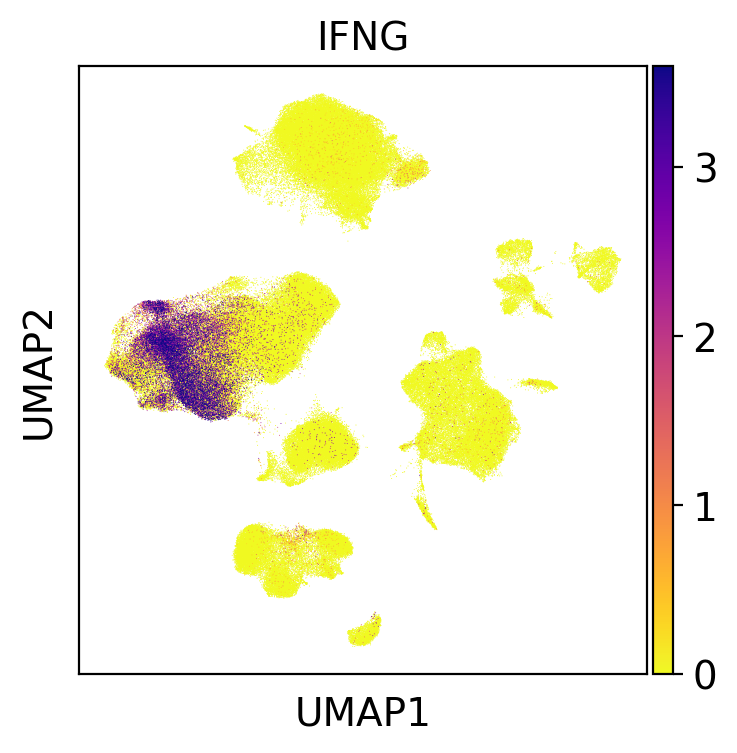

In [23]:
sc.pl.umap(
    adata,
    color=["IFNG"],
    use_raw=True,
    vmin=0.0,
    vmax="p99",
    color_map="plasma_r",
    show=True,
)

### plot therapy umap

In [24]:
adata.obs["Therapy"] 

SMC01-T_AAACCTGCATACGCCG-SMC         naive
SMC01-T_AAACCTGGTCGCATAT-SMC         naive
SMC01-T_AAACCTGTCCCTTGCA-SMC         naive
SMC01-T_AAACGGGAGGGAAACA-SMC         naive
SMC01-T_AAACGGGGTATAGGTA-SMC         naive
                                     ...  
P17_Colon_T_TAAGCCATCTATCGCC-1-Wu    naive
P17_Colon_T_TATACCTTCTAGTTCT-1-Wu    naive
P17_Colon_T_TTCTGTAGTGCATTAC-1-Wu    naive
P19_Colon_T_TCTAACTGTTGCTGAT-1-Wu      NAC
P20_Colon_T_ATCCCTGTCAAAGACA-1-Wu      NAC
Name: Therapy, Length: 246779, dtype: category
Categories (2, object): ['NAC', 'naive']

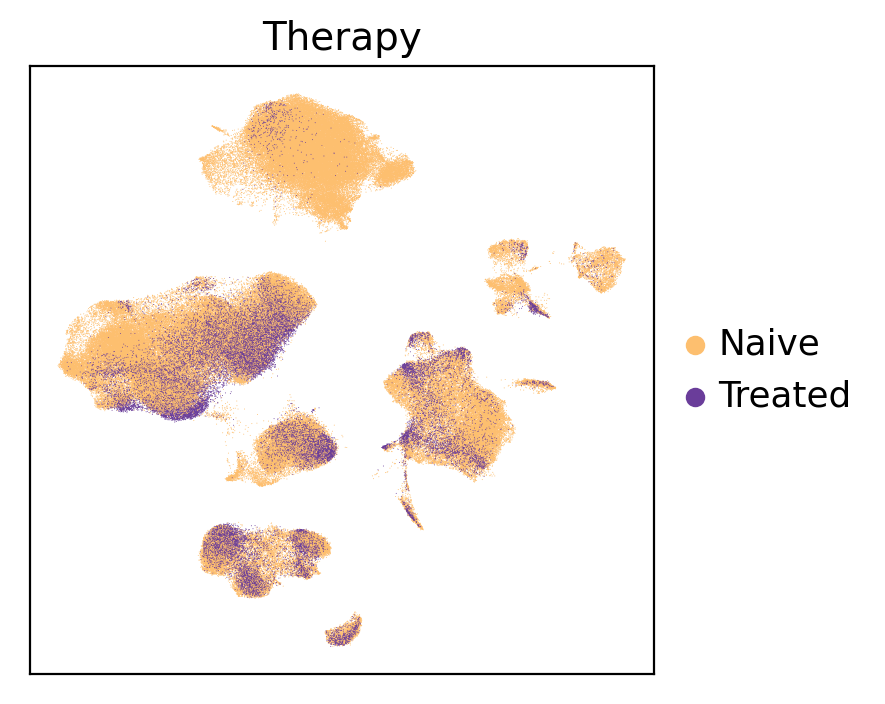

In [25]:
# change to Naive vs Treated
adata.obs["Therapy"] = np.where(adata.obs["Therapy"]=="naive", "Naive", "Treated")

fig, ax = plt.subplots(nrows=1, ncols=1)
sc.pl.umap(adata, color="Therapy", palette=["#fdbf6f","#6a3d9a"], 
           #save="CRCLM_cancerCells_therapy.pdf",
           ax=ax,
           show=False)
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_title("Therapy")
plt.savefig(FIG2SAVE.joinpath("CRCp_TME_therapy.pdf"), bbox_inches='tight', dpi=DPI)
